# Imports

## Packages

In [6]:
import os
import pandas as pd
import numpy as np
import random
import importlib
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_curve, auc
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from scipy import stats
from pylab import *
import seaborn as sns
import tensorflow as tf

from mlxtend.evaluate import paired_ttest_5x2cv

pd.set_option("display.max_rows", None, "display.max_columns", None)
plt.rcParams['figure.facecolor']='white'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Helpers

In [13]:
import sys
sys.path.append("../")

# glove preprocessings
import Helpers.Glove_transform
importlib.reload(Helpers.Glove_transform)
from Helpers.Glove_transform import GloveTransform

# Stanford tokenizer
import Helpers.Stanford_Tokenizer
importlib.reload(Helpers.Stanford_Tokenizer)
from Helpers.Stanford_Tokenizer import StanfordTokenizer

# Tweet tokenizer(from C-BiGRU paper)
import Helpers.Tweet_Tokenizer
importlib.reload(Helpers.Tweet_Tokenizer)
from Helpers.Tweet_Tokenizer import TweetTokenize

# glove embeddings
import Helpers.Glove_twitter_embeddings
importlib.reload(Helpers.Glove_twitter_embeddings)
from Helpers.Glove_twitter_embeddings import GloveTwitterEmbeddings

# glove common crawl
import Helpers.Glove_CommonCrawl_embeddings
importlib.reload(Helpers.Glove_CommonCrawl_embeddings)
from Helpers.Glove_CommonCrawl_embeddings import GloveCommomCrawlEmbeddings

# Word embedding(from C-BiGRU paper)
import Helpers.Word2Vec_Twitter
importlib.reload(Helpers.Word2Vec_Twitter)
from Helpers.Word2Vec_Twitter import Word2VecTwitter

# Fasttext embedding
import Helpers.Fasttext_Twitter
importlib.reload(Helpers.Fasttext_Twitter)
from Helpers.Fasttext_Twitter import FasttextTwitter

# Padding
import Helpers.Padding
importlib.reload(Helpers.Padding)
from Helpers.Padding import Padding

# Kears sklearn CNN classifier
import Helpers.CNN_SciKeras_Classifier
importlib.reload(Helpers.CNN_SciKeras_Classifier)
from Helpers.CNN_SciKeras_Classifier import CNN_classifier

# Kears sklearn CBiGRU classifier
import Helpers.CBiGRU_SciKeras_Classifier
importlib.reload(Helpers.CBiGRU_SciKeras_Classifier)
from Helpers.CBiGRU_SciKeras_Classifier import CBiGRU_classifier

# Directory to store results

In [14]:
results_dir = Path('../../results/mmovet15')
results_dir.mkdir(parents=True, exist_ok=True)

results_plot = Path('../../results/plots')
results_plot.mkdir(parents=True, exist_ok=True)

# Dataset

## Train Datset

In [15]:
# read train dataset
MMoveT15 = "../../Datasets/Migration-Movement-2015/"
train = pd.read_json(MMoveT15 + 'train_data.json')
x_train = train["text"]
y_train = train["label"]
# label encoder
le = LabelEncoder()
y_train = le.fit_transform(y_train.values)
print("Total number of datapoints in train set:",len(x_train))

Total number of datapoints in train set: 2456


## Test Dataset

In [16]:
test = pd.read_json(MMoveT15 + 'test_data.json')
x_test = test["text"]
y_test = test["label"]
# label encoder
le = LabelEncoder()
y_test = le.fit_transform(y_test.values)
print("Total number of datapoints in test set:",len(y_test))

Total number of datapoints in test set: 819


## Class weights

In [17]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train      
                                    )

class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.5833729216152019, 1: 3.4985754985754984}

# Experiments

## SVM + TF-IDF

### Pipeline

In [18]:
# Define component objects of our pipeline then create it!
objs = [("tfidf", TfidfVectorizer(ngram_range=(1,2))),
        ("svm", SVC(kernel="linear", probability=True))]
pipe = Pipeline(objs)
pipe.named_steps

{'tfidf': TfidfVectorizer(ngram_range=(1, 2)),
 'svm': SVC(kernel='linear', probability=True)}

### Cross validation

In [19]:
cv = cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
pipe.set_params(svm__C=10.0)
pipe.set_params(tfidf__ngram_range=(1, 2))
cv_results = cross_validate(pipe, 
                                x_train, y_train,
                                cv=cv, 
                                n_jobs = -1,
                                scoring=["average_precision", "f1_macro", "accuracy"])

In [20]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results["test_f1_macro"]), np.std(cv_results["test_f1_macro"])))
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results["test_average_precision"]), np.std(cv_results["test_average_precision"])))
print("Accuracy: Mean-%.3f, std-%.3f"%(np.mean(cv_results["test_accuracy"]), np.std(cv_results["test_accuracy"])))

F1_Macro: Mean-0.858, std-0.030
Average Precision: Mean-0.858, std-0.045
Accuracy: Mean-0.931, std-0.015


In [21]:
results = pd.DataFrame(cv_results)[["test_average_precision", "test_f1_macro"]]
results.rename(columns={"test_average_precision": "Average Precision", "test_f1_macro": "F1 Macro"}, inplace=True)
results.to_csv(Path.joinpath(results_dir, "SVM_TFIDF.csv"), index=False)

## CNN + Glove Twitter Word Embeddings

### Pipeline

In [22]:
objs_CNN = [
     ("Preprocess", GloveTransform()),
        ("Tokenize", StanfordTokenizer()),
        ("W2V", GloveTwitterEmbeddings(transformTo="concat")),
        ("Pad", Padding()),
        ("net", CNN_classifier())
              ] 
pipe_CNN = Pipeline(objs_CNN)

pipe_CNN.named_steps

{'Preprocess': GloveTransform(),
 'Tokenize': StanfordTokenizer(),
 'W2V': GloveTwitterEmbeddings(transformTo='concat'),
 'Pad': Padding(),
 'net': CNN_classifier(
 	model=<function CNN_model at 0x7f5b19809ee0>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=<keras.optimizer_v2.adadelta.Adadelta object at 0x7f5b19833dc0>
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=50
 	validation_batch_size=None
 	verbose=1
 	callbacks=None
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=40
 	class_weight=None
 )}

### Cross validation

In [23]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
pipe_CNN.set_params(net__verbose=0)
cv_results_CNN = cross_validate(pipe_CNN, 
                            x_train, 
                            y_train,
                            cv=cv,
                            n_jobs=-1,
                            scoring=["average_precision", "f1_macro"])

In [24]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_f1_macro"]), np.std(cv_results_CNN["test_f1_macro"])))
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_average_precision"]), np.std(cv_results_CNN["test_average_precision"])))

F1_Macro: Mean-0.853, std-0.034
Average Precision: Mean-0.859, std-0.037


In [25]:
results = pd.DataFrame(cv_results_CNN)[["test_average_precision", "test_f1_macro"]]
results.rename(columns={"test_average_precision": "Average Precision", "test_f1_macro": "F1 Macro"}, inplace=True)
results.to_csv(Path.joinpath(results_dir, "Glove_Twitter_Embeddings_CNN.csv"), index=False)

### Hypothesis Test for Comparing SVM+TF-IDF and CNN+Glove Twitter

In [26]:
SVM_results = pd.read_csv(Path.joinpath(results_dir, "SVM_TFIDF.csv"))
CNN_results = pd.read_csv(Path.joinpath(results_dir, "Glove_Twitter_Embeddings_CNN.csv"))

ttest = stats.ttest_ind(SVM_results["Average Precision"], CNN_results["Average Precision"])
print("P Value:", ttest.pvalue)
# interpret the result
if ttest.pvalue <= 0.05:
    print('Difference between mean performance is probably real')
else:
    print('Algorithms probably have the same performance')

P Value: 0.9520712074985671
Algorithms probably have the same performance


### Plot training loss curve

In [27]:
x_transform = pipe_CNN[:-1].fit_transform(x_train)
x_transform.shape

(2456, 29, 200)

In [28]:
model = CNN_classifier(verbose=0)
model.fit(x_transform, y_train)

CNN_classifier(
	model=<function CNN_model at 0x7f5b19809ee0>
	build_fn=None
	warm_start=False
	random_state=42
	optimizer=<keras.optimizer_v2.adadelta.Adadelta object at 0x7f5b19833dc0>
	loss=binary_crossentropy
	metrics=['accuracy']
	batch_size=50
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.1
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
	model__seq_len=29
	model__emb_dim=200
)

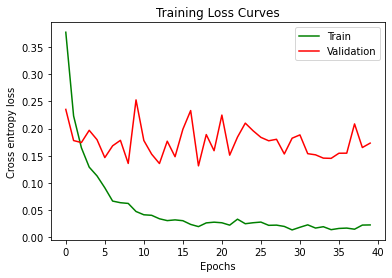

In [29]:
# get training and validation loss
epochs = [i for i in range(len(model.history_["loss"]))]
train_loss = model.history_['loss']
train_acc = model.history_['accuracy']
valid_loss = model.history_['val_loss']
valid_acc = model.history_['val_accuracy']

plt.plot(epochs,train_loss,'g-');
plt.plot(epochs,valid_loss,'r-');
# plt.plot(epochs,valid_acc,'b-');
# plt.plot(epochs,train_acc,'y-');
plt.title('Training Loss Curves');
plt.xlabel('Epochs');
plt.ylabel('Cross entropy loss');
plt.legend(['Train','Validation', "Val Accuracy", "Train Accuracy"]);
plt.savefig(Path.joinpath(results_plot, "MMoveT15_loss_cruve.pdf"))
plt.show()

### Precision Recall curve

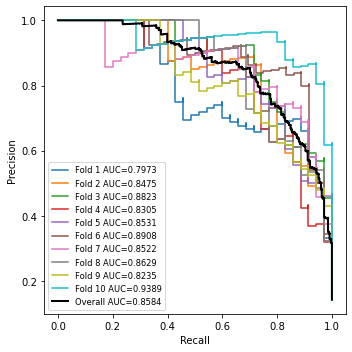

In [30]:
f, axes = plt.subplots(1, 1, figsize=(5, 5))
y_real = []
y_proba = []
pipe_CNN.set_params(net__verbose=0)

for i, (train_index, test_index) in enumerate(cv.split(x_train, y_train)):
    Xtrain, Xtest = x_train[train_index], x_train[test_index]
    ytrain, ytest = y_train[train_index], y_train[test_index]
    pipe_CNN.fit(Xtrain, ytrain)
    pred_proba = pipe_CNN.predict_proba(Xtest)
    precision, recall, _ = precision_recall_curve(ytest, pred_proba[:,1])
    lab = 'Fold %d AUC=%.4f' % (i+1, auc(recall, precision))
    axes.step(recall, precision, label=lab)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])

y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
lab = 'Overall AUC=%.4f' % (auc(recall, precision))
axes.step(recall, precision, label=lab, lw=2, color='black')
axes.set_xlabel('Recall')
axes.set_ylabel('Precision')
axes.legend(loc='lower left', fontsize='small')

f.tight_layout()
plt.savefig(Path.joinpath(results_plot, "MMoveT15_PR_AUC.pdf"))

## CNN + Glove Common Crawl Word Embeddings

### Pipeline

In [31]:
objs_CNN = [
     ("Preprocess", GloveTransform()),
        ("Tokenize", StanfordTokenizer()),
        ("W2V", GloveCommomCrawlEmbeddings(transformTo="concat")),
        ("Pad", Padding()),
        ("net", CNN_classifier())
              ] 
pipe_CNN = Pipeline(objs_CNN)

pipe_CNN.named_steps

{'Preprocess': GloveTransform(),
 'Tokenize': StanfordTokenizer(),
 'W2V': GloveCommomCrawlEmbeddings(transformTo='concat'),
 'Pad': Padding(),
 'net': CNN_classifier(
 	model=<function CNN_model at 0x7f5b19809ee0>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=<keras.optimizer_v2.adadelta.Adadelta object at 0x7f5b19833dc0>
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=50
 	validation_batch_size=None
 	verbose=1
 	callbacks=None
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=40
 	class_weight=None
 )}

### Cross validation

In [32]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
pipe_CNN.set_params(net__verbose=0)
cv_results_CNN = cross_validate(pipe_CNN, 
                            x_train, 
                            y_train,
                            cv=cv,
                            n_jobs=-1,
                            scoring=["average_precision", "f1_macro"])

In [33]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_f1_macro"]), np.std(cv_results_CNN["test_f1_macro"])))
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_average_precision"]), np.std(cv_results_CNN["test_average_precision"])))

F1_Macro: Mean-0.847, std-0.037
Average Precision: Mean-0.848, std-0.040


In [34]:
results = pd.DataFrame(cv_results_CNN)[["test_average_precision", "test_f1_macro"]]
results.rename(columns={"test_average_precision": "Average Precision", "test_f1_macro": "F1 Macro"}, inplace=True)
results.to_csv(Path.joinpath(results_dir, "Glove_Common_Crawl_Embeddings_CNN.csv"), index=False)

## CNN + Word2Vec Twitter Embeddings

### Pipeline

In [35]:
objs_CNN = [
     ("Preprocess", GloveTransform()),
        ("Tokenize", StanfordTokenizer()),
        ("W2V", Word2VecTwitter(transformTo="concat")),
        ("Pad", Padding()),
        ("net", CNN_classifier())
              ] 
pipe_CNN = Pipeline(objs_CNN)

pipe_CNN.named_steps

{'Preprocess': GloveTransform(),
 'Tokenize': StanfordTokenizer(),
 'W2V': Word2VecTwitter(transformTo='concat'),
 'Pad': Padding(),
 'net': CNN_classifier(
 	model=<function CNN_model at 0x7f5b19809ee0>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=<keras.optimizer_v2.adadelta.Adadelta object at 0x7f5b19833dc0>
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=50
 	validation_batch_size=None
 	verbose=1
 	callbacks=None
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=40
 	class_weight=None
 )}

### Cross validation

In [36]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
pipe_CNN.set_params(net__verbose=0)
cv_results_CNN = cross_validate(pipe_CNN, 
                            x_train, 
                            y_train,
                            cv=cv,
                            n_jobs=-1,
                            scoring=["average_precision", "f1_macro"])

In [37]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_f1_macro"]), np.std(cv_results_CNN["test_f1_macro"])))
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_average_precision"]), np.std(cv_results_CNN["test_average_precision"])))

F1_Macro: Mean-0.837, std-0.033
Average Precision: Mean-0.830, std-0.046


In [38]:
results = pd.DataFrame(cv_results_CNN)[["test_average_precision", "test_f1_macro"]]
results.rename(columns={"test_average_precision": "Average Precision", "test_f1_macro": "F1 Macro"}, inplace=True)
results.to_csv(Path.joinpath(results_dir, "Word2Vec_Twitter_CNN.csv"), index=False)

## CNN + FastText Twitter Embeddings

### Pipeline

In [39]:
objs_CNN = [
     ("Preprocess", GloveTransform()),
        ("Tokenize", StanfordTokenizer()),
        ("Fasttext", FasttextTwitter(transformTo="concat")),
        ("Pad", Padding()),
        ("net", CNN_classifier())
              ] 
pipe_CNN = Pipeline(objs_CNN)

pipe_CNN.named_steps

{'Preprocess': GloveTransform(),
 'Tokenize': StanfordTokenizer(),
 'Fasttext': FasttextTwitter(transformTo='concat'),
 'Pad': Padding(),
 'net': CNN_classifier(
 	model=<function CNN_model at 0x7f5b19809ee0>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=<keras.optimizer_v2.adadelta.Adadelta object at 0x7f5b19833dc0>
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=50
 	validation_batch_size=None
 	verbose=1
 	callbacks=None
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=40
 	class_weight=None
 )}

### Cross validation

In [40]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
pipe_CNN.set_params(net__verbose=0)
cv_results_CNN = cross_validate(pipe_CNN, 
                            x_train, 
                            y_train,
                            cv=cv,
                            n_jobs=2,
                            scoring=["average_precision", "f1_macro"])

/root/anaconda3/envs/thesis/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [41]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_f1_macro"]), np.std(cv_results_CNN["test_f1_macro"])))
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_average_precision"]), np.std(cv_results_CNN["test_average_precision"])))

F1_Macro: Mean-0.833, std-0.045
Average Precision: Mean-0.834, std-0.052


In [42]:
results = pd.DataFrame(cv_results_CNN)[["test_average_precision", "test_f1_macro"]]
results.rename(columns={"test_average_precision": "Average Precision", "test_f1_macro": "F1 Macro"}, inplace=True)
results.to_csv(Path.joinpath(results_dir, "FastText_Twitter_CNN.csv"), index=False)

## C-BiGRU + Glove Twitter Word Embeddings

### Pipeline

In [43]:
objs_CBiGRU = [("Tokenize", TweetTokenize()),
        ("W2V", GloveTwitterEmbeddings(transformTo="concat")),
        ("Pad", Padding(seq_length=150)),
        ("net", CBiGRU_classifier())
              ] 
pipe_CBiGRU = Pipeline(objs_CBiGRU)

pipe_CBiGRU.named_steps

{'Tokenize': TweetTokenize(),
 'W2V': GloveTwitterEmbeddings(transformTo='concat'),
 'Pad': Padding(seq_length=150),
 'net': CBiGRU_classifier(
 	model=<function CBiGRU_model at 0x7f5b19837940>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=adam
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=32
 	validation_batch_size=None
 	verbose=1
 	callbacks=[<keras.callbacks.EarlyStopping object at 0x7f5b198339d0>]
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=5
 	class_weight=None
 )}

### Cross validation

In [44]:
pipe_CBiGRU.set_params(net__verbose=0)
pipe_CBiGRU.set_params(net__class_weight = class_weights)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results_CBiGRU = cross_validate(pipe_CBiGRU,
                                   x_train,
                                   y_train,
                                   cv=cv,
                                   n_jobs = -1,
                                   scoring=["average_precision", "f1_macro"])

In [45]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_f1_macro"]), np.std(cv_results_CBiGRU["test_f1_macro"])))
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_average_precision"]), np.std(cv_results_CBiGRU["test_average_precision"])))

F1_Macro: Mean-0.758, std-0.043
Average Precision: Mean-0.686, std-0.063


In [46]:
results = pd.DataFrame(cv_results_CBiGRU)[["test_average_precision", "test_f1_macro"]]
results.rename(columns={"test_average_precision": "Average Precision", "test_f1_macro": "F1 Macro"}, inplace=True)
results.to_csv(Path.joinpath(results_dir, "Glove_Twitter_Embeddings_CBiGRU.csv"), index=False)

### Hypothesis Test for Comparing CNN+Glove and C-BiGRU+Glove

In [47]:
CNN_results = pd.read_csv(Path.joinpath(results_dir, "Glove_Twitter_Embeddings_CNN.csv"))
CBiGRU_results = pd.read_csv(Path.joinpath(results_dir, "Glove_Twitter_Embeddings_CBiGRU.csv"))

ttest = stats.ttest_ind(CBiGRU_results["Average Precision"], CNN_results["Average Precision"])

# interpret the result
if ttest.pvalue <= 0.05:
    print('Difference between mean performance is probably real')
else:
    print('Algorithms probably have the same performance')

Difference between mean performance is probably real


## C-BiGRU + Glove Common Crawl Word Embeddings

### Pipeline

In [48]:
objs_CBiGRU = [("Tokenize", TweetTokenize()),
        ("W2V", GloveCommomCrawlEmbeddings(transformTo="concat")),
        ("Pad", Padding(seq_length=150)),
        ("net", CBiGRU_classifier())
              ] 
pipe_CBiGRU = Pipeline(objs_CBiGRU)

pipe_CBiGRU.named_steps

{'Tokenize': TweetTokenize(),
 'W2V': GloveCommomCrawlEmbeddings(transformTo='concat'),
 'Pad': Padding(seq_length=150),
 'net': CBiGRU_classifier(
 	model=<function CBiGRU_model at 0x7f5b19837940>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=adam
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=32
 	validation_batch_size=None
 	verbose=1
 	callbacks=[<keras.callbacks.EarlyStopping object at 0x7f5b198339d0>]
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=5
 	class_weight=None
 )}

### Cross validation

In [49]:
pipe_CBiGRU.set_params(net__verbose=0)
pipe_CBiGRU.set_params(net__class_weight = class_weights)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results_CBiGRU = cross_validate(pipe_CBiGRU,
                                   x_train,
                                   y_train,
                                   cv=cv,
                                   n_jobs = -1,
                                   scoring=["average_precision", "f1_macro"])

In [50]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_f1_macro"]), np.std(cv_results_CBiGRU["test_f1_macro"])))
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_average_precision"]), np.std(cv_results_CBiGRU["test_average_precision"])))

F1_Macro: Mean-0.799, std-0.050
Average Precision: Mean-0.755, std-0.066


In [51]:
results = pd.DataFrame(cv_results_CBiGRU)[["test_average_precision", "test_f1_macro"]]
results.rename(columns={"test_average_precision": "Average Precision", "test_f1_macro": "F1 Macro"}, inplace=True)
results.to_csv(Path.joinpath(results_dir, "Glove_Common_Crawl_Embeddings_CBiGRU.csv"), index=False)

## C-BiGRU + Word2Vec Twitter Embeddings

### Pipeline

In [52]:
objs_CBiGRU = [("Tokenize", TweetTokenize()),
        ("W2V", Word2VecTwitter(transformTo="concat")),
        ("Pad", Padding(seq_length=150)),
        ("net", CBiGRU_classifier())
              ] 
pipe_CBiGRU = Pipeline(objs_CBiGRU)

pipe_CBiGRU.named_steps

{'Tokenize': TweetTokenize(),
 'W2V': Word2VecTwitter(transformTo='concat'),
 'Pad': Padding(seq_length=150),
 'net': CBiGRU_classifier(
 	model=<function CBiGRU_model at 0x7f5b19837940>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=adam
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=32
 	validation_batch_size=None
 	verbose=1
 	callbacks=[<keras.callbacks.EarlyStopping object at 0x7f5b198339d0>]
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=5
 	class_weight=None
 )}

### Cross validation

In [53]:
pipe_CBiGRU.set_params(net__verbose=0)
pipe_CBiGRU.set_params(net__class_weight = class_weights)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results_CBiGRU = cross_validate(pipe_CBiGRU,
                                   x_train,
                                   y_train,
                                   cv=cv,
                                   n_jobs = -1,
                                   scoring=["average_precision", "f1_macro"])

In [54]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_f1_macro"]), np.std(cv_results_CBiGRU["test_f1_macro"])))
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_average_precision"]), np.std(cv_results_CBiGRU["test_average_precision"])))

F1_Macro: Mean-0.758, std-0.044
Average Precision: Mean-0.717, std-0.057


In [55]:
results = pd.DataFrame(cv_results_CBiGRU)[["test_average_precision", "test_f1_macro"]]
results.rename(columns={"test_average_precision": "Average Precision", "test_f1_macro": "F1 Macro"}, inplace=True)
results.to_csv(Path.joinpath(results_dir, "Word2Vec_Twitter_CBiGRU.csv"), index=False)

In [56]:
# check if difference between algorithms is real
pipe_CNN.set_params(net__verbose=0)
pipe_CBiGRU.set_params(net__verbose=0)
t, p = paired_ttest_5x2cv(estimator1=pipe_CNN, estimator2=pipe_CBiGRU, X=x_train, y=y_train, scoring='average_precision', random_seed=42)
# summarize
print('P-value: %.3f, t-Statistic: %.3f' % (p, t))
# interpret the result
if p <= 0.05:
    print('Difference between mean performance is probably real')
else:
    print('Algorithms probably have the same performance')

P-value: 0.262, t-Statistic: 1.263
Algorithms probably have the same performance


## C-BiGRU + FastText Twitter Embeddings

### Pipeline

In [57]:
objs_CBiGRU = [("Tokenize", TweetTokenize()),
        ("W2V", FasttextTwitter(transformTo="concat")),
        ("Pad", Padding(seq_length=150)),
        ("net", CBiGRU_classifier())
              ] 
pipe_CBiGRU = Pipeline(objs_CBiGRU)

pipe_CBiGRU.named_steps

{'Tokenize': TweetTokenize(),
 'W2V': FasttextTwitter(transformTo='concat'),
 'Pad': Padding(seq_length=150),
 'net': CBiGRU_classifier(
 	model=<function CBiGRU_model at 0x7f5b19837940>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=adam
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=32
 	validation_batch_size=None
 	verbose=1
 	callbacks=[<keras.callbacks.EarlyStopping object at 0x7f5b198339d0>]
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=5
 	class_weight=None
 )}

### Cross validation

In [58]:
pipe_CBiGRU.set_params(net__verbose=0)
pipe_CBiGRU.set_params(net__class_weight = class_weights)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results_CBiGRU = cross_validate(pipe_CBiGRU,
                                   x_train,
                                   y_train,
                                   cv=cv,
                                   scoring=["average_precision", "f1_macro"])

INFO:tensorflow:Assets written to: ram:///tmp/tmpuqwaya4_/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpuqwaya4_/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmps5ga8k1s/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmps5ga8k1s/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp3syqxyg7/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp3syqxyg7/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp4n4u0ntb/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp4n4u0ntb/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpv529b539/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpv529b539/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpe_jc_3rm/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpe_jc_3rm/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpdj8rpta9/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpdj8rpta9/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpxk6eppj8/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpxk6eppj8/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpzzveuuuv/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpzzveuuuv/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp7p365x8g/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp7p365x8g/assets


In [59]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_f1_macro"]), np.std(cv_results_CBiGRU["test_f1_macro"])))
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_average_precision"]), np.std(cv_results_CBiGRU["test_average_precision"])))

F1_Macro: Mean-0.777, std-0.047
Average Precision: Mean-0.725, std-0.086


In [60]:
results = pd.DataFrame(cv_results_CBiGRU)[["test_average_precision", "test_f1_macro"]]
results.rename(columns={"test_average_precision": "Average Precision", "test_f1_macro": "F1 Macro"}, inplace=True)
results.to_csv(Path.joinpath(results_dir, "FastText_Twitter_CBiGRU.csv"), index=False)

# Hypothesis Test

## Average Precision

In [61]:
SVM_results = pd.read_csv(Path.joinpath(results_dir, "SVM_TFIDF.csv"))

for i, file in enumerate(os.listdir(results_dir)):
    if "SVM" not in file:
        other_results = pd.read_csv(Path.joinpath(results_dir, file))
        print(file.replace(".csv",""))

        ttest = stats.ttest_ind(SVM_results["Average Precision"], other_results["Average Precision"])

        # interpret the result
        if ttest.pvalue <= 0.05:
            print('Difference between mean performance is probably real')
        else:
            print('Algorithms probably have the same performance')
        print("------------------------------------------------------")

Glove_Common_Crawl_Embeddings_CNN
Algorithms probably have the same performance
------------------------------------------------------
FastText_Twitter_CNN
Algorithms probably have the same performance
------------------------------------------------------
Glove_Twitter_Embeddings_CNN
Algorithms probably have the same performance
------------------------------------------------------
FastText_Twitter_CBiGRU
Difference between mean performance is probably real
------------------------------------------------------
Glove_Twitter_Embeddings_CBiGRU
Difference between mean performance is probably real
------------------------------------------------------
Glove_Common_Crawl_Embeddings_CBiGRU
Difference between mean performance is probably real
------------------------------------------------------
Word2Vec_Twitter_CBiGRU
Difference between mean performance is probably real
------------------------------------------------------
Word2Vec_Twitter_CNN
Algorithms probably have the same performan

## F1 Macro

In [62]:
SVM_results = pd.read_csv(Path.joinpath(results_dir, "SVM_TFIDF.csv"))

for i, file in enumerate(os.listdir(results_dir)):
    if "SVM" not in file:
        other_results = pd.read_csv(Path.joinpath(results_dir, file))
        print(file.replace(".csv",""))

        ttest = stats.ttest_ind(SVM_results["F1 Macro"], other_results["F1 Macro"])

        # interpret the result
        if ttest.pvalue <= 0.05:
            print('Difference between mean performance is probably real')
        else:
            print('Algorithms probably have the same performance')
        print("------------------------------------------------------")

Glove_Common_Crawl_Embeddings_CNN
Algorithms probably have the same performance
------------------------------------------------------
FastText_Twitter_CNN
Algorithms probably have the same performance
------------------------------------------------------
Glove_Twitter_Embeddings_CNN
Algorithms probably have the same performance
------------------------------------------------------
FastText_Twitter_CBiGRU
Difference between mean performance is probably real
------------------------------------------------------
Glove_Twitter_Embeddings_CBiGRU
Difference between mean performance is probably real
------------------------------------------------------
Glove_Common_Crawl_Embeddings_CBiGRU
Difference between mean performance is probably real
------------------------------------------------------
Word2Vec_Twitter_CBiGRU
Difference between mean performance is probably real
------------------------------------------------------
Word2Vec_Twitter_CNN
Algorithms probably have the same performan

# Plots

In [63]:
data = pd.DataFrame(columns=["x_axis","Average Precision", "F1 Macro", "Experiments", "Model"])
for i, file in enumerate(os.listdir(results_dir)):
        data_sample = pd.read_csv(Path.joinpath(results_dir, file))
        if "CNN" in file:
            data_sample["Model"] = "CNN"
            file = file.replace("CNN", "")
        elif "CBiGRU" in file:
            data_sample["Model"] = "C-BiGRU"
            file = file.replace("CBiGRU", "")
        else: data_sample["Model"] = "SVM"
        data_sample["Experiments"] = file.replace("_", "\n").replace(".csv","")
        data_sample["x_axis"]=i
        data = pd.concat([data, data_sample[["x_axis","Average Precision", "F1 Macro", "Experiments", "Model"]]])
        
data = data.astype({"Experiments":"category", "Model":"category", "x_axis": "category", "F1 Macro":"float64", "Average Precision":"float64"})

In [64]:
grp = data.groupby(['Model', 'Experiments'])['Average Precision'].mean().sort_values().iloc[::-1]
grp_index = grp[~grp.isna()].index 
seen = set()
seen_add = seen.add
order = [x[1] for x in grp_index if not (x[1] in seen or seen_add(x[1]))][::-1]

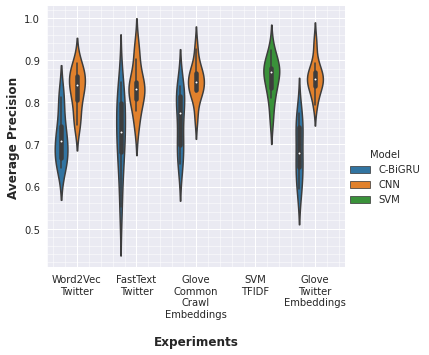

In [65]:
sns.set_style("darkgrid")
 
g = sns.catplot(x="Experiments", y="Average Precision",
               data=data, kind="violin", hue="Model", order=order)

for ax in g.axes.flat:
    ax.get_xaxis().set_minor_locator(AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(AutoMinorLocator())
    ax.grid(visible=True, which='major', color='w', linewidth=1.0)
    ax.grid(visible=True, which='minor', color='w', linewidth=0.5)

xlabel('Experiments', fontsize=12, fontweight='bold')
ylabel('Average Precision', fontsize=12, fontweight='bold')    
plt.savefig(Path.joinpath(results_plot, "MMoveT15.pdf"))
plt.show()